<a href="https://colab.research.google.com/github/bigCow13/Python_Code/blob/main/Wallstreetbets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wallstreebets playaround - WIP

# Environment

## Packages 
This section contains packages to be used throughout the notebook

In [ ]:
## Packages for general use 
# Data Management.
import pandas as pd
import numpy as np

# Data Manipulation
import itertools
import statistics
import random 

# Datetime Manipulation
import datetime as dt
from datetime import datetime
from dateutil import tz
import time

# Text manipulation
import re 

# Tracking run-time
from tqdm.notebook import tqdm
tqdm.pandas()

# Reddit scraper
# Limited posts - try others
!pip install praw
import praw

# Scraper using Pushshift
! pip install psaw
from psaw import PushshiftAPI

# Used in pulling info from wikipedia/yahoo finance
import bs4 as bs
import pickle
import requests
import os
import pandas_datareader.data as web

# Import the yfinance
!pip install yfinance
import yfinance as yf

# Regular expression
import re

# Plotting
import matplotlib.pyplot as plt

## Functions

This section contains functions used throughout the notebook. 

In [ ]:
# Collect tickers of current S&P 500 companies
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)

    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)

    return tickers
  
# Collect names of current S&P 500 companies
def save_sp500_names():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    names = []
    for row in table.findAll('tr')[1:]:
        stockname = row.findAll('td')[1].text
        names.append(stockname)

    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(names,f)

    return names


# Function using yfinance, adding ticker name to each download
def download_price(stock_ticker, start_date, end_date):
    df_stock = yf.download(stock_ticker, start_date, end_date)
    df_stock['ticker'] = stock_ticker
    return df_stock


# Function for text cleaning of post titles
def reddit_post_cleaner(text): 

# Lower case
    text = text.lower() 
# Remove dollar signs , hashtags and question marks
    text = re.sub(r"\$", "", text)
    text = re.sub(r"\#", "", text)
# Remove apostrophes
    text = re.sub(r"\b's", "", text) 
    text = re.sub(r"\b’s", "", text) 
# Tokenisation  
    text = text.split() 
    return text

# Functions to find stock names/tickers in the posts
def stock_find(x):
    stock_find = [stock for stock in df_stocknames['StockNames'] if stock in x]
    return stock_find

def ticker_find(x):
    ticker_find = [ticker for ticker in df_stocknames['tickers'] if ticker in x]
    return ticker_find

# 

def stock_logic(x,y):
    return_stock = '' 
    if len(x)!= 0:
        return_stock = x[0]
    elif len(y)!= 0:
        return_stock = stock_dict.get(y[0])
    else:
        return_stock = 'remove'
    return return_stock

def convert_seconds_datetime(x):
    formatdate = time.gmtime(x)
    formatdate = dt.datetime(*formatdate[:6])
    return formatdate    


def closest_time(x):
    closest_date = min([d for d in times if d > x], key = lambda t: t - x)
    return closest_date

## Data

This section creates the datasets required and will be web-scraping for wsb posts and stock price data.

Due to time it takes to scrape reddit posts, will save point in time data into drive. 

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# Load wsb posts from drive
infolder = '/content/gdrive/My Drive/Datasets/'
file_name_prices = 'wsb_posts.csv'
df = pd.read_csv(infolder+file_name_prices)

# Load prices from drive
infolder = '/content/gdrive/My Drive/Datasets/'
file_name_prices = 'ticker_prices.csv'
df_prices = pd.read_csv(infolder+file_name_prices)

In [ ]:
df['dt'] = [convert_seconds_datetime(i) for i in df['created']] 
df['year'] = [i.year for i in df['dt']]
df['month'] = [i.month for i in df['dt']]
df_2021_12 = df.loc[(df['year'] == 2021) & (df['month'] == 11)]

WSB posts


In [ ]:
#Enter reddit login info
r = praw.Reddit(client_id='G_BrE-lY8IRfDDJ9mQw9Eg', client_secret='_1MiajxVKgxGAJ6H-pz_ogEIV0IsIQ', user_agent='WebScraping')
api = PushshiftAPI(r)


start_epoch= int(dt.datetime(2019, 6, 1).timestamp())

wsb_posts = list(api.search_submissions(after=start_epoch,
                            subreddit='wallstreetbets',
                            filter=['url','author', 'title', 'num_comments'],
                            limit=1_000_000))
# Create empty list
df = []

# Create df
for post in wsb_posts:
    df.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
df = pd.DataFrame(df,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])

# Write to csv
df.to_csv('/content/gdrive/My Drive/Datasets/wsb_posts.csv')

S&P500 Composites prices

In [ ]:
## Get S&P 500 data
## Tickers from 'functions'
#tickers = save_sp500_tickers()
#tickers = [re.sub(r"\n", "", x)for x in tickers]

## Names from function in 'functions'
#spnames = save_sp500_names()
#
## Add GME
#spnames.append('GameStop')
#tickers.append('GME')
#
#spnames.append('AMC')
#tickers.append('AMC')
#
## Create dataframe
#df_stocknames = pd.DataFrame()
#df_stocknames['StockNames'] = spnames
#df_stocknames['tickers'] = tickers
#
## Download prices using yfinance and function above
#df_prices = [download_price(stock,'2017-01-01','2021-12-01') for stock in df_stocknames['tickers']]
#
## Concat list of prices into df
#df_prices = pd.concat(df_prices)
#
## Write to csv
#df_prices.to_csv('/content/gdrive/My Drive/Datasets/ticker_prices.csv')

# Exploratory Data Analysis (EDA)

### Investigate share price data

In [ ]:
print(df_prices.shape)
print(df_prices.info())

(617575, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617575 entries, 0 to 617574
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       617575 non-null  object 
 1   Open       617575 non-null  float64
 2   High       617575 non-null  float64
 3   Low        617575 non-null  float64
 4   Close      617575 non-null  float64
 5   Adj Close  617575 non-null  float64
 6   Volume     617575 non-null  float64
 7   ticker     617575 non-null  object 
dtypes: float64(6), object(2)
memory usage: 37.7+ MB
None


In [ ]:
# Number of at distinct companies picked up from S&P500
print('Number of distinct companies:' + str (len(df_prices['ticker'].unique()))) 

Number of distinct companies:504


Plot Apple price - Check against google to check data pulled correctly

In [ ]:
aapl = df_prices.loc[df_prices['ticker'] == 'AAPL']

# Visualise Volume and Close price over time
# Set up plot
fig, ax1 = plt.subplots()
ax1.plot( aapl['Close'], color = 'dodgerblue', label = 'Close')

# Set labels
ax1.set_xlabel('Time')
ax1.set_ylabel('Close Price(USD)')

plt.title('AAPL - price over period')
plt.show()


Plot numerical features

Summary Statistics:
count    617575.000000
mean        134.902479
std         246.195054
min           0.700000
25%          48.500000
50%          82.809998
75%         145.130005
max        5327.109863
Name: Open, dtype: float64


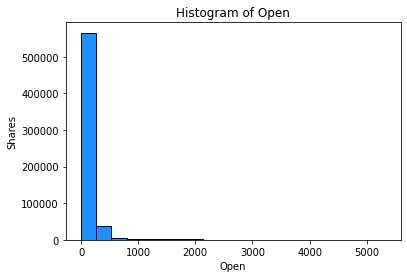

Summary Statistics:
count    617575.000000
mean        136.429902
std         249.138844
min           0.710000
25%          49.049999
50%          83.690002
75%         146.669998
max        5364.040039
Name: High, dtype: float64


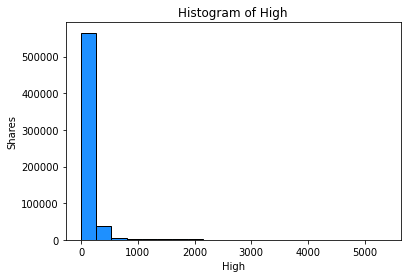

Summary Statistics:
count    617575.000000
mean        133.337401
std         243.275007
min           0.650000
25%          47.910000
50%          81.910004
75%         143.559998
max        5286.109863
Name: Low, dtype: float64


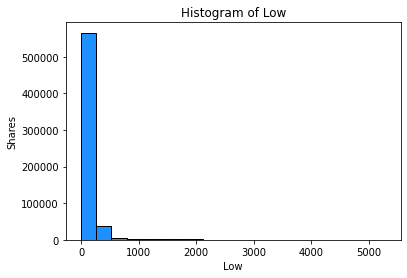

In [ ]:
import matplotlib.pyplot as plt
# Description of numerical variables & plot histogram
# Select numerical features to plot
num_features = ['Open', 'High', 'Low' ]
# Plot histogram
for x in num_features:
    print('Summary Statistics:')
    print(df_prices[x].describe(percentiles = [.25, .5, .75]))                  
    plt.hist(df_prices[x], color = 'dodgerblue', edgecolor = 'black',
         bins = int(20))
    plt.title('Histogram of '+ x)
    plt.xlabel(x)
    plt.ylabel('Shares')
    plt.show()

In [ ]:
print(df_prices.loc[df_prices['High']>5360])

              Date         Open         High  ...    Adj Close   Volume  ticker
427741  2021-11-24  5327.109863  5364.040039  ...  5351.399902  12700.0     NVR

[1 rows x 8 columns]


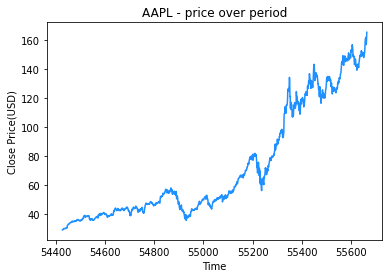

### Investigate wsb

In [ ]:
# Investigate posts
df.head(50)

,Unnamed: 0,title,score,id,subreddit,url,num_comments,body,created
0,0,What stock will make me rich?,1,r679m1,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,2,[removed],1.638336e+09
1,1,Stock Market Investors vs. Dig. Currency Inves...,1,r677ij,wallstreetbets,https://i.redd.it/0xo2vybc8v281.png,1,NaN,1.638336e+09
2,2,"WSB logo man is a real thing apparently….., we...",2,r676wt,wallstreetbets,https://i.redd.it/bhwbh1g78v281.jpg,1,NaN,1.638336e+09
3,3,Why did treasury rates fall if the fed confirm...,1,r676rt,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,1,[removed],1.638336e+09
4,4,WSB today,2,r676ni,wallstreetbets,https://i.redd.it/lpgwwl338v281.jpg,1,[deleted],1.638336e+09
5,5,Stock Market Investors vs. Digital Currency In...,1,r675tn,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,2,[removed],1.638336e+09
6,6,Anyone heard of profits unlimited? If you have...,1,r671ne,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,2,[removed],1.638335e+09
7,7,WSB Bulls When Futures Rip Green 🚀🚀🚀,1,r66xkc,wallstreetbets,https://i.redd.it/99i2gulf5v281.jpg,2,NaN,1.638335e+09
8,8,All the DD I ever needed for the future was a ...,6,r66xh6,wallstreetbets,https://v.redd.it/bcmfyhi45v281,3,NaN,1.638335e+09
9,9,WSV Bulls When Futures Rip Green,1,r66woz,wallstreetbets,https://i.redd.it/mm97lc175v281.jpg,2,[deleted],1.638335e+09


In [ ]:
#

# Analysis

### Finding mentions of a ticker


In [ ]:
# Prepare a dictionary of stocknames/tickers
# Get S&P 500 data
# Tickers from 'functions'
tickers = save_sp500_tickers()
tickers = [re.sub(r"\n", "", x)for x in tickers]

# Names from function in 'functions'
spnames = save_sp500_names()

# Add GME
spnames.append('GameStop')
tickers.append('GME')
spnames.append('AMC')
tickers.append('AMC')

# Create dataframe
df_stocknames = pd.DataFrame()
df_stocknames['StockNames'] = [x.lower() for x in spnames] 
df_stocknames['tickers'] = [x.lower() for x in tickers]
#df_stocknames

# Remove a list of tickers which will get picked up - check that they are nothing major
remove_list = ['a', 'all', 'it', 'are','now','dd','so']
df_stocknames = df_stocknames.loc[(~df_stocknames['tickers'].isin(remove_list))]

# Create a dictionary
stock_dict = dict(zip(df_stocknames.tickers, df_stocknames.StockNames))

In [ ]:
# Create Sample
test = df.copy()
test = test.loc[1:30000]

# Clean text
test['title_cleaned'] = [reddit_post_cleaner(x) for x in test['title']]

# Find stock names
test['stock_find'] = [stock_find(i) for i in test['title_cleaned']]
test['ticker_find'] = [ticker_find(i) for i in test['title_cleaned']]

# Logic to match to single
test['stock'] = test.apply(lambda x: stock_logic(x['stock_find'], x['ticker_find']), axis = 1)

In [ ]:
# Convert into a wide file with week as index, stock on columns and mentions as values

# Convert from seconds into datetime
test['dt'] = [convert_seconds_datetime(i) for i in test['created']] 

In [ ]:
#Summarise number of counts 
# List of stocknames
stock_names = df_stocknames['StockNames']

# times
times = pd.date_range('2016-01-01', periods=350, freq='7D')
test['week'] = [closest_time(i) for i  in test['dt'] ]

# Create pivot 
#pivot_tb = pd.pivot_table(test, index= 'week', columns='stock', aggfunc= 'count')

In [ ]:
pivot_tb = test[['week','stock']]
pivot_tb = pd.pivot_table(pivot_tb, index= 'week', columns='stock', aggfunc= len)
pivot_tb.drop('remove', axis = 1, inplace=True)

In [ ]:
pivot_tb

In [ ]:
!pip install bar_chart_race
import bar_chart_race as bcr
df = pivot_tb
bcr.bar_chart_race(
    df=df,
    filename='covid19_horiz.mp4',
    orientation='h',
    sort='desc',
    n_bars=6,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=10,
    interpolate_period=False,
    label_bars=True,
    bar_size=.95,
    period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
    period_fmt='%B %d, %Y',
    period_summary_func=lambda v, r: {'x': .99, 'y': .18,
                                      's': f'Total deaths: {v.nlargest(6).sum():,.0f}',
                                      'ha': 'right', 'size': 8, 'family': 'Courier New'},
    perpendicular_bar_func='median',
    period_length=500,
    figsize=(5, 3),
    dpi=144,
    cmap='dark12',
    title='Most Mentioned Stocks on WallStreetBets',
    title_size='',
    bar_label_size=7,
    tick_label_size=7,
    shared_fontdict={'family' : 'Helvetica', 'color' : '.1'},
    scale='linear',
    writer=None,
    fig=None,
    bar_kwargs={'alpha': .7},
    filter_column_colors=False)  

In [ ]:
bcr.bar_chart_race(df=df, filename=None,n_bars = 10)

# To Do


## Fixes

Currently the finding algorithm is quite bad - picking up exact matches only and for single words.

Treatment of tickers which are commonly used in language eg. 

## Planned Next Steps

Expand to include comments (might take too long to collect data on colab)
Correlation between prices and ticker mentions



# Appendix

In [ ]:
## Set up reddit login
reddit = praw.Reddit(client_id='G_BrE-lY8IRfDDJ9mQw9Eg', client_secret='_1MiajxVKgxGAJ6H-pz_ogEIV0IsIQ', user_agent='WebScraping')

## Import data
## Create empty list
wsb_posts = []
#
## Define parameters to pull in data
wsb = reddit.subreddit('wallstreetbets').top('year',limit=1000)
for post in wsb:
   wsb_posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])

wsb_posts = pd.DataFrame(wsb_posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])

print(wsb_posts)